In [1]:
%cd "~/code/snet/moses-incons-pen-xp"
%load_ext autoreload
%autoreload
%matplotlib inline

/home/xabush/code/snet/moses-incons-pen-xp


In [2]:
# import jax.numpy as np
import numpy as np
import jax
import jax.random as rng
import jax.numpy as jnp
import numpyro as npyro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
import arviz as az
import scipy
import scipy.stats as st
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from notebooks.variable_selection.MosesEstimator import *
from notebooks.variable_selection.util import *
from sklearn.model_selection import train_test_split, KFold
import warnings
warnings.filterwarnings('ignore')

In [3]:
### Python version of Jonathan's code to generate synth network
def gen_synth_net(num_feats, p=0.3):
    J = np.zeros((num_feats, num_feats))
    for i in range(num_feats):
        for j in range(i+1, num_feats):
            u = np.random.uniform()
            if u < p:
                r = st.halfnorm().rvs()
                # r = 1
                J[i, j] = r
                J[j, i] = r

    return J

def samples_to_feats(samples):
    feats = []
    for i in range(samples.shape[0]):
        feat_idx = list(np.nonzero(samples[i])[0])
        if len(feat_idx) == 0 or feat_idx in feats: continue
        feats.append(feat_idx)
    return feats

def rank_by_mi(samples, J, X, Y, eta=1.0, B=1.0):
    samples_c = samples.reshape((samples.shape[0]*samples.shape[1], samples.shape[2]))
    samples_unq = np.unique(samples_c, axis=0)
    energy_vals = [bmm_energy(samples_unq[i], J, eta=eta) for i in range(samples_unq.shape[0])]
    feats = samples_to_feats(samples_unq)
    mi_scores = []
    for eng, feat in zip(energy_vals, feats):
        s_score = 0.0
        for f in feat:
            mi = mutual_info_score(Y, X[:,f])
            s_score += mi

        mi_scores.append(s_score - B*eng)

    idxs = np.argsort(np.array(mi_scores))[::-1]
    feats = list(np.array(feats)[idxs])

    return feats, np.sort(np.array(mi_scores))[::-1]

def rank_by_cond_prob(samples, J, X_train, y_train, energy_fn, eta=1.0):
    samples_c = samples.reshape((samples.shape[0]*samples.shape[1], samples.shape[2]))
    samples_unq = np.unique(samples_c, axis=0)
    prob_vals = [np.exp(-energy_fn(samples_unq[i], J, X=X_train, Y=y_train, eta=eta)) for i in range(samples_unq.shape[0])]
    idx = np.argsort(np.array(prob_vals))[::-1]
    samples_unq = samples_unq[idx]
    feats = samples_to_feats(samples_unq)
    return feats

def get_rand_feats(p, n=100):
    feats = []
    for i in range(n):
        idx = np.random.randint(0, 2, size=p)
        feats.append(list(np.nonzero(idx)[0]))

    return feats

def plot_energy_model(J, net_energy, net_spins, samples, energy_fn, X=None, Y=None, eta=1.0):
    chains, num_samples, n_dim = samples.shape
    samples = samples.reshape((chains*num_samples, n_dim))
    energy_vals = [energy_fn(samples[i], J, X, Y, eta=eta) for i in range(samples.shape[0])]
    prob_vals = [np.exp(-e) for e in energy_vals]
    fig, ax = plt.subplots(2, 2, figsize=(24, 18))
    s = np.arange(1, net_energy.shape[1] + 1)
    t = np.arange(1, samples.shape[0] + 1)
    for i in range(net_energy.shape[0]):
        ax[0, 0].plot(s, net_energy[i])
        ax[1, 0].plot(s, net_spins[i])

    ax[0, 1].plot(t, energy_vals)
    ax[1, 1].plot(t, prob_vals)

    ax[0, 0].set(title="Net Energy over Time", xlabel="Time", ylabel="$E(\gamma)$")
    ax[1, 0].set(title="Net spins over Time", xlabel="Time", ylabel="Sping")
    ax[0, 1].set(title="Energy for 10000 samples", xlabel="i", ylabel="$E(\gamma)$")
    ax[1, 1].set(title="Probability for 10000 samples", xlabel="i", ylabel="$p(\gamma)$")

    return energy_vals, prob_vals

def logistic(x):
    return 1/(1 + jnp.exp(-x))

def jax_prng_key():
    return jax.random.PRNGKey(np.random.randint(int(1e5)))

def hamm(a,b):
    return len(np.nonzero(a != b)[0])


def generate_potential_energy_fn(X, y, J, sigma, mu):
    X = jax.device_put(X)
    y = jax.device_put(y)
    J = jax.device_put(J)
    mu = jax.device_put(mu)
    # sigma = jax.device_put(sigma)
    beta_dist = distrax.MultivariateNormalFullCovariance(sigma)
    def potential_energy(gamma, beta):
        gamma_f = gamma.astype(jnp.float32)
        # beta_prior_potential = jnp.sum(
        #     0.5 * jnp.log(2 * jnp.pi * sigma ** 2) + 0.5 * beta ** 2 / sigma ** 2
        # )
        beta_prior_potential = beta_dist.log_prob(beta)
        probs = 1 / (
                1 + jnp.exp(-jnp.dot(jnp.dot(X, jnp.diag(gamma_f)), beta))
        )
        likelihood_potential = -jnp.sum(
            y * jnp.log(probs + 1e-12) + (1 - y) * jnp.log(1 - probs + 1e-12)
        )

        gamma_potential = -0.5*jnp.dot(jnp.dot(gamma_f.T, J), gamma_f) + mu*jnp.sum(gamma_f)

        return beta_prior_potential + likelihood_potential + gamma_potential

    return potential_energy

def is_related_to_causal(J, causal_feats):
    s = J.shape[0]
    r = np.zeros(s, dtype=np.int)
    for i in range(s):
        for f in causal_feats:
            if i == f or J[i, f] != 0: r[i] = 1

    return r

In [32]:
np.random.seed(1234)
X, beta, y = generate_data_v2(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], corr=0.7, n=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
y_train_c = y_train.copy()
y_test_c = y_test.copy()
y_train_c[y_train_c == 0] = -1
y_test_c[y_test_c == 0] = -1
J = get_assoc_mat(20, 10, 1)
L = scipy.sparse.csgraph.laplacian(J, normed=True)
rng_key, rng_key_predict = rng.split(rng.PRNGKey(1234))
p = X.shape[1]
X.shape

(100, 220)

In [33]:
rng_key

DeviceArray([2113592192, 1902136347], dtype=uint32)

In [13]:
sigma = 25*np.identity(p)
L, _ = scipy.linalg.cho_factor(sigma, lower=True)
import numpyro.distributions as dist
dist.LowRankMultivariateNormal(np.zeros(p), L, np.diagonal(L))

In [34]:
from numpyro.infer import MCMC, MixedHMC, HMC
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform

def gamma_energy(gamma, J, eta, mu):
    return 0.5*eta*jnp.dot(jnp.dot(gamma.T, J), gamma) - mu*jnp.sum(gamma)

def model(X, y=None, sigma=None, J=None, eta=1.0):

    L = np.linalg.cholesky(sigma)
    mu = npyro.sample("mu" ,dist.Gamma(2, 1))
    z = npyro.sample('z', dist.Normal(np.zeros(p), 1))
    beta = npyro.deterministic('beta', L @ z)
    gamma = npyro.sample('gamma', dist.Bernoulli(np.full(p, 0.5)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    prob = npyro.deterministic("prob", jnp.dot(X, (beta * gamma)))
    # print(f"Probs: {prob.shape}")
    # likelihood = npyro.sample("y", dist.Bernoulli(logits=prob),
    #                           obs=y)
    likelihood = npyro.sample("y", dist.Normal(prob),
                              obs=y)

# model_reparm = npyro.handlers.reparam(model, config = {"beta": LocScaleReparam(centered=0)})
sigma = 0.3 * np.ones((p, p))
np.fill_diagonal(sigma, 25)
#
kernel = MixedHMC(HMC(model), random_walk=False,)
mcmc = MCMC(kernel, num_warmup=300, num_samples=1000, num_chains=2, progress_bar=True)
mcmc.run(rng_key, X_train, y_train, sigma, J, 1.0)

warmup:   1%|                   | 7/1300 [1:10:47<217:55:43, 606.76s/it, 1517083 steps of size 2.69e-07. acc. prob=0.00]


KeyboardInterrupt: 

In [35]:

import arviz as az
infr_data = az.from_numpyro(mcmc)
az.plot_trace(infr_data, var_names=["beta"])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
az.plot_trace(infr_data, var_names=["mu"])

In [18]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[1]      0.79      0.41      1.00      0.00      1.00     60.45      1.00
  gamma[2]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[3]      0.64      0.48      1.00      0.00      1.00     59.49      1.01
  gamma[4]      0.86      0.35      1.00      0.00      1.00     37.79      1.06
  gamma[5]      0.95      0.21      1.00      1.00      1.00     65.49      1.01
  gamma[6]      0.97      0.16      1.00      1.00      1.00     74.44      1.02
  gamma[7]      0.93      0.26      1.00      1.00      1.00     68.46      1.00
  gamma[8]      0.60      0.49      1.00      0.00      1.00     20.93      1.15
  gamma[9]      1.00      0.00      1.00      1.00      1.00       nan       nan
 gamma[10]      0.62      0.48      1.00      0.00      1.00     69.59      1.05
 gamma[11]      1.00      0

In [19]:
gamma_samples_2 = jax.device_get(mcmc.get_samples()["gamma"])
beta_samples_2 = jax.device_get(mcmc.get_samples()["beta"])

In [62]:
jnp.save("data/gamma_samples_nb_14.npy",gamma_samples)
jnp.save("data/beta_samples_nb_14.npy", beta_samples)

In [3]:
gamma_samples = jnp.load("data/gamma_samples_nb_14.npy")
beta_samples = jnp.load("data/beta_samples_nb_14.npy")

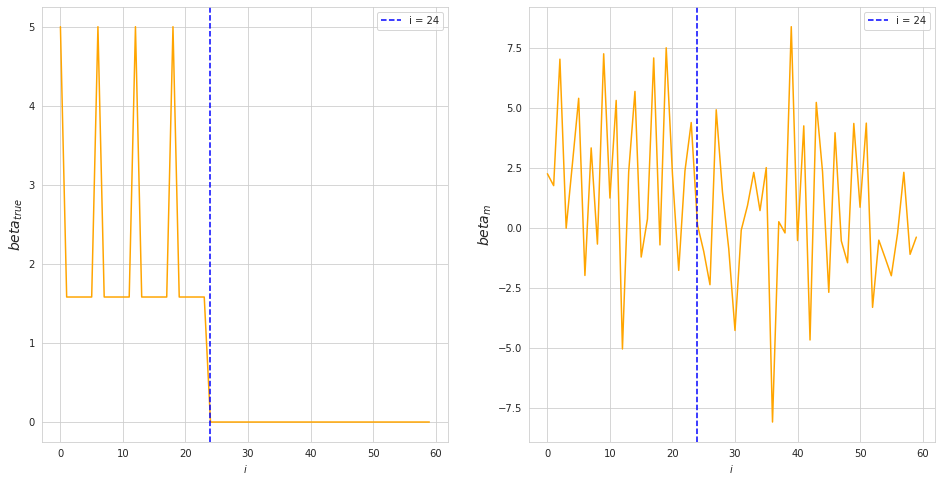

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].plot(np.arange(0, 60), beta, color="orange")
ax[0].axvline(x=24, linestyle="--", color="blue", label="i = 24")
ax[1].plot(np.arange(0, 60), np.mean(beta_samples_2, axis=0), color="orange")
ax[1].axvline(x=24, linestyle="--", color="blue", label="i = 24")

ax[0].set_xlabel("$i$")
ax[1].set_xlabel("$i$")
ax[0].set_ylabel("$beta_{true}$", fontsize=14)
ax[1].set_ylabel("$beta_m$", fontsize=14)
ax[0].legend()
ax[1].legend()

In [24]:
%autoreload
calculate_sens_spec(np.mean(beta_samples_2, axis=0))

tp: 44, fp: 16, fn: 0, tn: 0


(1.0, 0.0)

In [27]:
from numpyro.infer import Predictive
cov = np.cov(beta_samples_2, rowvar=False)
predictive = Predictive(model, mcmc.get_samples())
preds_train = predictive(rng_key, X_train, None, sigma, J, 1.0)
preds_test = predictive(rng_key, X_test, None, sigma, J, 1.0)

In [28]:
y_pred_train = jnp.mean(jax.device_get(preds_train["y"]), axis=0)
print(mean_squared_error(y_train, y_pred_train))
y_pred_test = jnp.mean(jax.device_get(preds_test["y"]), axis=0)
print(mean_squared_error(y_test, y_pred_test))

0.12964854635491796
249.3027453796388


[Text(0, 0.5, 'y_test'), Text(0.5, 0, 'i')]

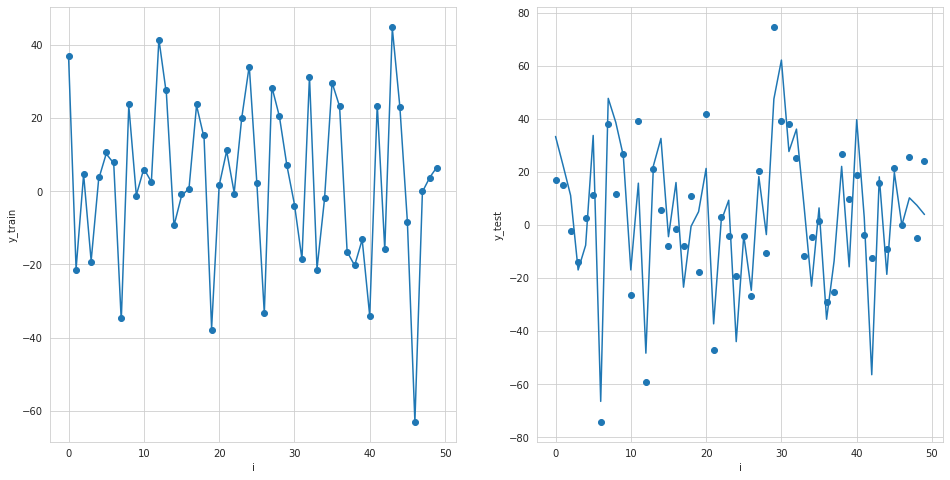

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(np.arange(y_train.shape[0]), y_train)
ax[0].plot(np.arange(y_train.shape[0]), y_pred_train)
ax[1].scatter(np.arange(y_test.shape[0]), y_test)
ax[1].plot(np.arange(y_test.shape[0]), y_pred_test)

ax[0].set(ylabel="y_train", xlabel="i")
ax[1].set(ylabel="y_test", xlabel="i")

In [79]:
def model_2(X, y=None, sigma=None, J=None):

    L = np.linalg.cholesky(sigma)
    eta = npyro.sample("eta", dist.LogNormal())
    mu  = npyro.sample("mu", dist.Normal())
    z = npyro.sample('z', dist.Normal(np.zeros(p), 1))
    beta = npyro.deterministic('beta', L @ z)
    gamma = npyro.sample('gamma', dist.Bernoulli(np.full(p, 0.5)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    prob = npyro.deterministic("prob", jnp.dot(X, (beta * gamma)))
    # print(f"Probs: {prob.shape}")
    # likelihood = npyro.sample("y", dist.Bernoulli(logits=prob),
    #                           obs=y)
    likelihood = npyro.sample("y", dist.Normal(prob),
                              obs=y)

sigma = 0.3 * np.ones((p, p))
np.fill_diagonal(sigma, 25)

kernel_2 = MixedHMC(HMC(model_2), random_walk=False)
mcmc_2 = MCMC(kernel_2, num_warmup=300, num_samples=1000, num_chains=4, progress_bar=True)
mcmc_2.run(rng_key, X_train, y_train, sigma, J)

warmup:   1%|▏                                          | 7/1300 [59:43<183:51:39, 511.91s/it, 1517097 steps of size 2.69e-07. acc. prob=0.00]


KeyboardInterrupt: 

In [97]:
samples = gamma_samples.reshape((-1, gamma_samples.shape[-1]))
samples.shape

(4000, 220)

In [98]:
bin_count = np.bincount(
    np.sum(samples == (beta > 0).astype(np.int32).reshape((1, -1)), axis=1),
    minlength=beta.shape[0],
)
bin_count

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   5,  10,  51, 128, 158, 296, 397, 445, 658, 469, 302,  73,
        34,  81, 185, 269, 282, 100,  42,  15,   0,   0,   0,   

In [73]:
print('Correct percentage: {}'.format(bin_count[-1] / np.sum(bin_count)))

Correct percentage: 0.0


In [106]:
np.mean(
    np.sum(samples != (beta > 0).astype(np.int32).reshape((1, -1)), axis=1))/ beta.shape[0]

0.24459999999999998

In [99]:
gamma_unq, gamma_idx, gamma_count = np.unique(gamma_samples, return_counts=True, axis=0, return_index=True)
gamma_count

array([2, 1, 1, ..., 1, 4, 1])

In [96]:
np.sum((samples == (beta > 0).astype(np.int32).reshape((1, -1))), axis=1).shape

(4000,)

In [104]:
np.bincount(np.sum(samples[0:3] == (beta > 0).astype(np.int32).reshape((1, -1)), axis=1), minlength=beta.shape[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [89]:
beta_samples_unq = beta_samples[gamma_idx]
beta_samples_unq.shape

(1090, 220)

In [78]:
from scripts.samplers import generate_potential_energy_fn
cov = np.cov(beta_samples_unq, rowvar=False)
mean = np.mean(beta_samples_unq, axis=0)
potential_fn = generate_potential_energy_fn(X_train, y_train, J, cov, 1.0, 1.0, mean)

In [85]:
c

array([1, 1, 3, ..., 1, 1, 2])

In [79]:
k = gamma_unq.shape[0]
gamma_eng = np.zeros(k)
for i in range(k):
    gamma_eng[i] = potential_fn(gamma_unq[i], beta_samples_unq[i])

In [80]:
np.s(gamma_eng)

array([564, 231, 685, ..., 446, 240, 266])

In [81]:
gamma_unq[564]

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int32)

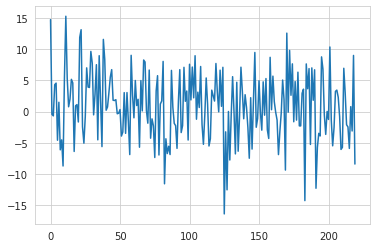

In [90]:
plt.plot(np.arange(p), beta_samples_unq[924])

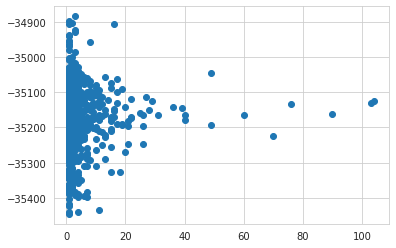

In [84]:
plt.scatter(gamma_count, gamma_eng)